In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [31]:
biogrid = pd.read_csv('BIOGRID2.tab.txt', sep='\t')


In [32]:
biogrid.head()

,OFFICIAL_SYMBOL_A,OFFICIAL_SYMBOL_B
0,MAP2K4,FLNC
1,MYPN,ACTN2
2,ACVR1,FNTA
3,GATA2,PML
4,RPA2,STAT3


In [ ]:
""" biogrid = biogrid[['Official Symbol Interactor A','Official Symbol Interactor B','Score']]
biogrid = biogrid[biogrid['Score'] != '-']

biogrid['Score'] = pd.to_numeric(biogrid['Score'])
biogrid['Score'] = biogrid['Score'].apply(lambda x: 0 if x < 0 else x)
biogrid.reset_index(drop=True, inplace=True)
biogrid.head() """

In [34]:
genesA = biogrid['OFFICIAL_SYMBOL_A'].tolist()
genesB = biogrid['OFFICIAL_SYMBOL_B'].tolist()
genes = genesA + genesB
genes = list(dict.fromkeys(genes))


In [6]:
endometriosis = pd.read_csv('genes_for_protein/ENDOMETRIOSIS.txt', sep = '\t', header=None)
endometriosis = endometriosis.rename(columns={0:'Gene'})

In [7]:

endometriosis.head()

,Gene
0,LACTBL1
1,WNT4
2,GREB1
3,RMND1
4,CCDC170


In [8]:
G = nx.Graph()

for index, row in biogrid.iterrows():
    source_node = row['Official Symbol Interactor A']
    target_node = row['Official Symbol Interactor B']
       
    G.add_edge(source_node, target_node)

In [30]:
G.degree['TP53']


2323

In [22]:
nodes = endometriosis['Gene'].tolist()
subset_of_nodes = nodes[:100]

# Create a new graph to store the shortest paths
H = nx.Graph()

# Find the shortest path between each pair of nodes in the subset
for i in range(len(subset_of_nodes)):
    for j in range(i + 1, len(subset_of_nodes)):
        node_i = subset_of_nodes[i]
        node_j = subset_of_nodes[j]
        
        # Check if both nodes exist in graph G
        if node_i in G and node_j in G:
            try:
                # Calculate shortest path if nodes exist in G
                path = nx.shortest_path(G, node_i, node_j)
                if len(path) <= 4:
                    #print(path)
                    path_edges = [(path[k], path[k+1]) for k in range(len(path)-1)]
                    #print(path_edges)
                    H.add_edges_from(path_edges)
            except nx.NetworkXNoPath:
                continue
        else:
            continue

# Find the minimum spanning tree of the new graph
mst = nx.minimum_spanning_tree(H, algorithm='kruskal')

# Print the edges of the minimum spanning tree
for edge in mst.edges(data=True):
    node1, node2 = edge[0], edge[1]
    print(f"Edge: {node1} -- {node2}")


Edge: LACTBL1 -- PRC1
Edge: PRC1 -- TOMM40
Edge: PRC1 -- TRIM25
Edge: PRC1 -- DDRGK1
Edge: PRC1 -- RBM17
Edge: PRC1 -- FAF2
Edge: PRC1 -- CUL2
Edge: PRC1 -- IQGAP1
Edge: PRC1 -- SAP18
Edge: PRC1 -- APC
Edge: PRC1 -- YWHAG
Edge: PRC1 -- FZR1
Edge: PRC1 -- CBX1
Edge: PRC1 -- NPM1
Edge: PRC1 -- NDUFS1
Edge: PRC1 -- EEF1G
Edge: PRC1 -- DDX54
Edge: PRC1 -- NDEL1
Edge: PRC1 -- TFIP11
Edge: PRC1 -- TRA2A
Edge: PRC1 -- CTNNB1
Edge: PRC1 -- SRP14
Edge: PRC1 -- CDKN2A
Edge: PRC1 -- FBXW7
Edge: PRC1 -- TRAP1
Edge: PRC1 -- MRPL12
Edge: PRC1 -- DDB1
Edge: PRC1 -- ELAVL1
Edge: PRC1 -- ESR2
Edge: PRC1 -- EGFR
Edge: PRC1 -- GNAI1
Edge: PRC1 -- SYNE1
Edge: PRC1 -- PLK1
Edge: PRC1 -- TMPO
Edge: PRC1 -- KIAA1429
Edge: PRC1 -- ZC3HAV1
Edge: PRC1 -- LYAR
Edge: PRC1 -- ATG16L1
Edge: PRC1 -- LGALS1
Edge: PRC1 -- HNRNPL
Edge: PRC1 -- PPP2R1B
Edge: PRC1 -- ACTN3
Edge: PRC1 -- CCT5
Edge: PRC1 -- CHD4
Edge: PRC1 -- Plk1
Edge: PRC1 -- IFI30
Edge: PRC1 -- HLTF
Edge: PRC1 -- CCDC85B
Edge: PRC1 -- ACIN1
Edge: PRC1 -

In [14]:
print(subset_of_nodes)

['LACTBL1', 'WNT4', 'GREB1', 'RMND1', 'CCDC170', 'FSHB', 'ARL14EP', 'HOXB2', 'SNX11', 'SKAP1']


In [ ]:
""" 
# Extract node positions for plotting
pos = nx.spring_layout(mst, seed=42)

# Create Plotly figure for interactive visualization
fig = go.Figure()

# Add nodes to the figure
for node in mst.nodes:
    x, y = pos[node]
    fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers+text', marker=dict(size=0), text=node, textposition="middle center", name=node))

# Add edges of MST to the figure
for edge in mst.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x=[x0, x1], y=[y0, y1], mode='lines', line=dict(width=2, color='red'), name=f"{edge[0]} - {edge[1]}"))

# Update layout options
fig.update_layout(
    title='Minimum Spanning Tree Visualization',
    showlegend=False,
    hovermode='closest',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

# Show the interactive plot
fig.show()
 """

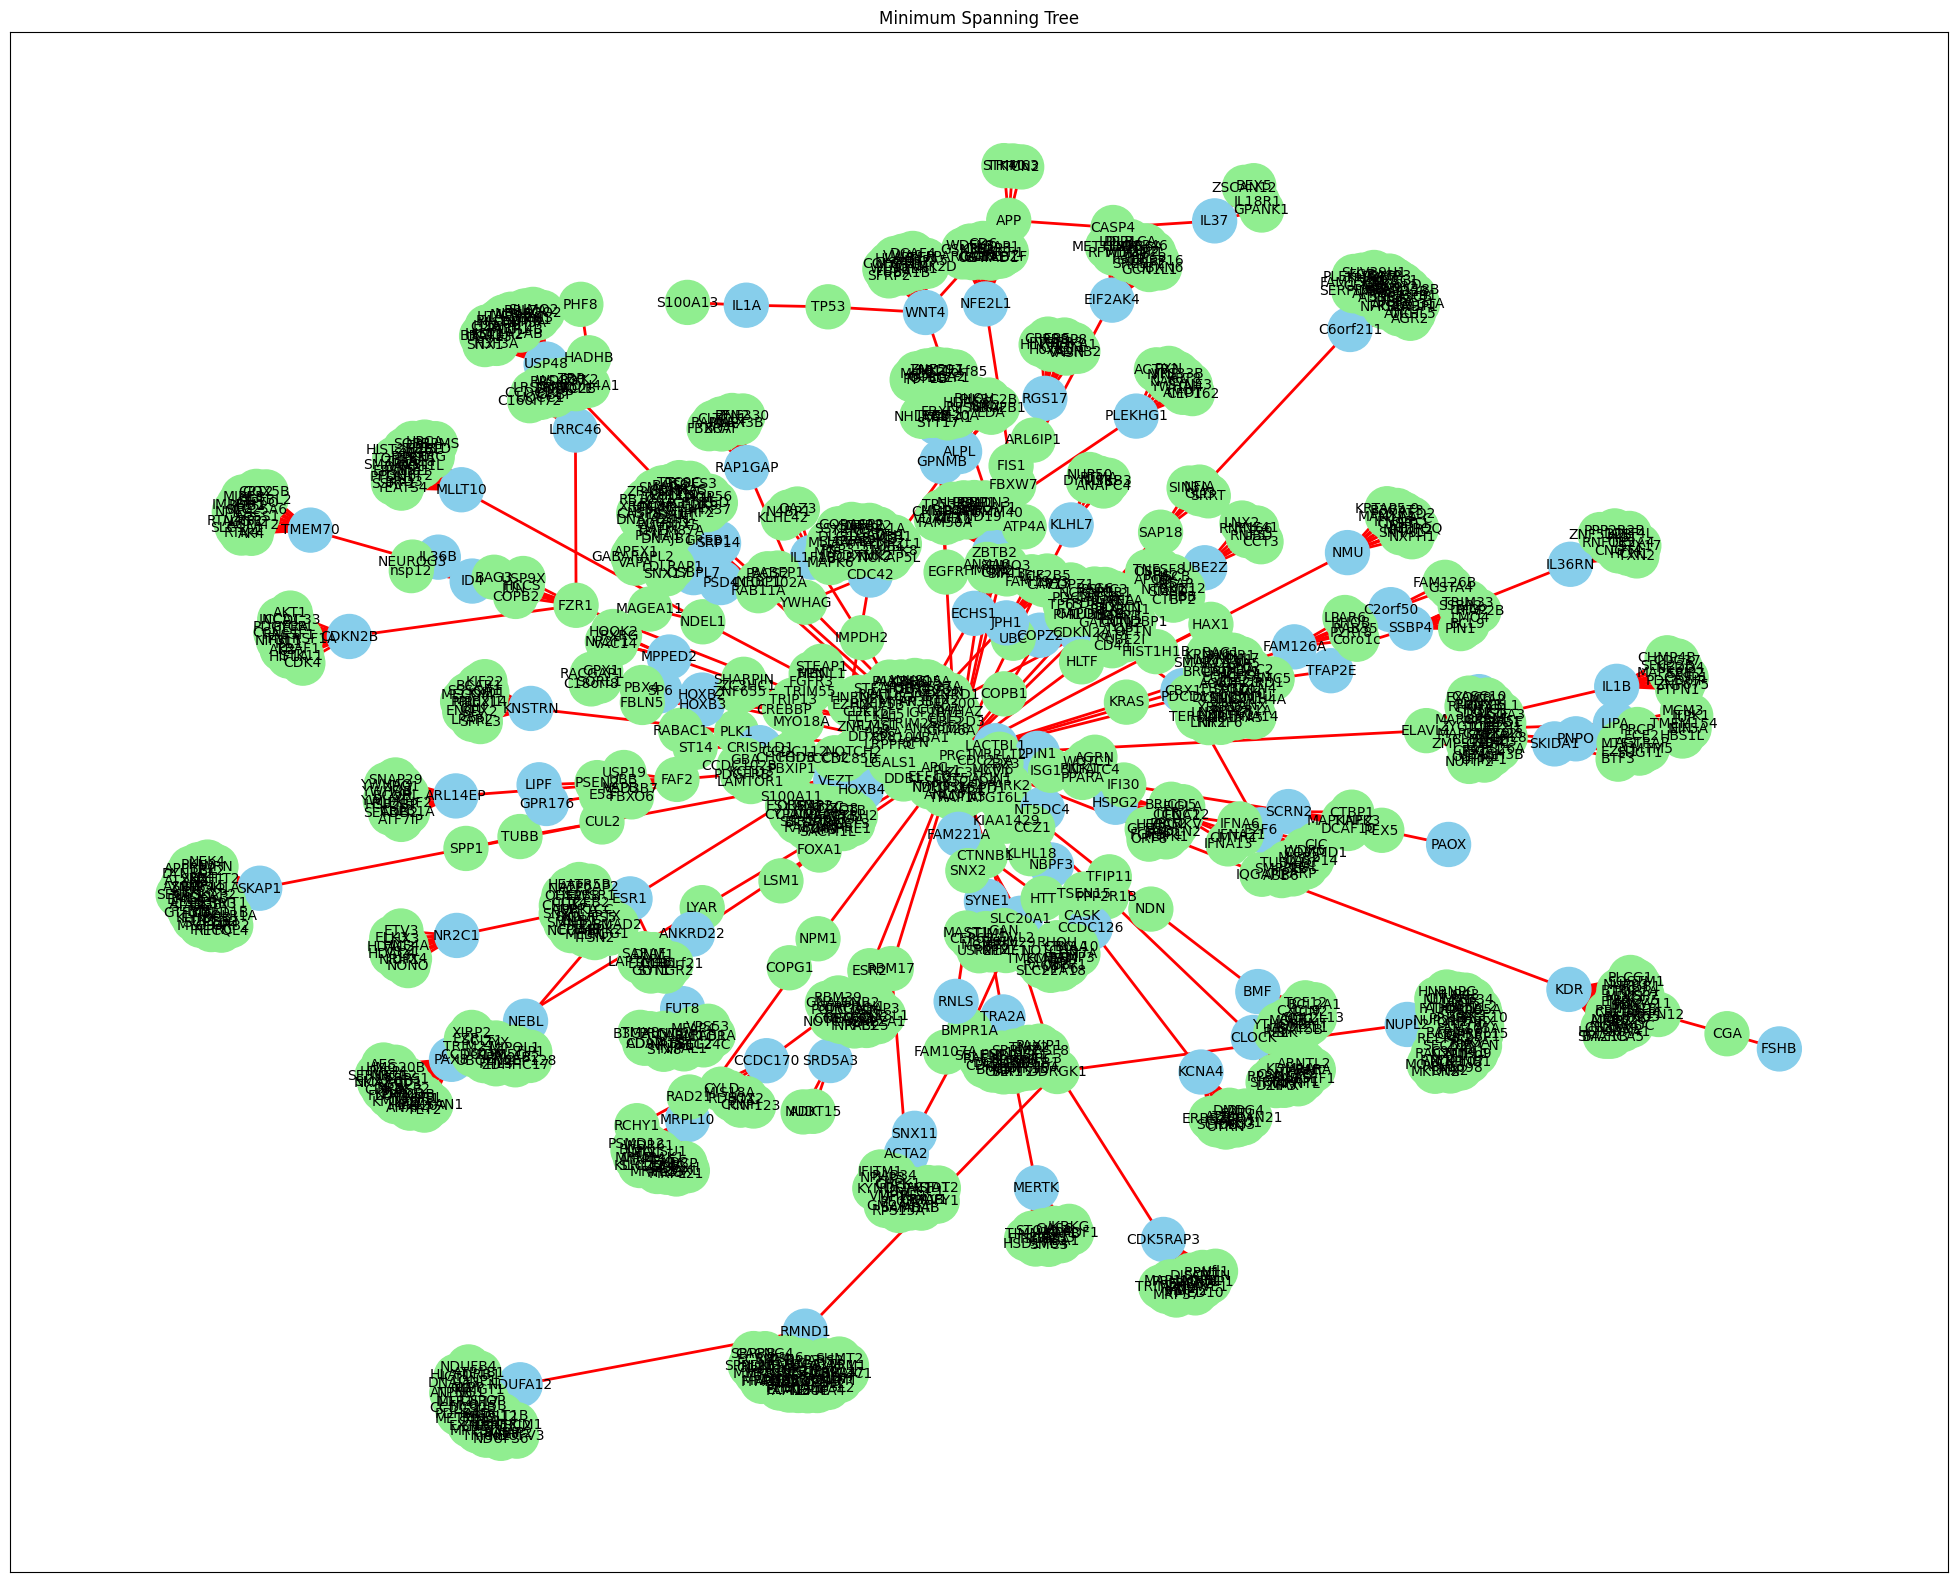

In [23]:
node_colors = ['skyblue' if node in subset_of_nodes else 'lightgreen' for node in mst.nodes]

# Plot the MST
plt.figure(figsize=(25,20))  # Set the figure size

# Extract positions for the nodes using a layout algorithm (e.g., spring layout)
pos = nx.spring_layout(mst, seed=42)

# Draw the nodes
nx.draw_networkx_nodes(mst, pos, node_size=1000, node_color=node_colors)

# Draw the edges
nx.draw_networkx_edges(mst, pos, edge_color='red', width=2)

# Add labels to the nodes
nx.draw_networkx_labels(mst, pos, font_size=10, font_color='black', font_family='sans-serif')

# Set the title of the plot
plt.title("Minimum Spanning Tree")

# Remove axis ticks
plt.xticks([])
plt.yticks([])

# Show the plot
plt.show()